In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dummy Data ---
cycles = np.arange(1, 11)

flow = {
    "Lane A": np.array([12, 14, 13, 15, 16, 14, 15, 17, 16, 18]),
    "Lane B": np.array([18, 20, 21, 19, 22, 20, 21, 23, 22, 24]),
    "Lane C": np.array([10,  9, 11, 12, 10, 11, 12, 13, 12, 14])
}

avg_speed = {
    "Lane A": np.array([12, 11, 12, 13, 12, 11, 12, 13, 12, 14]),
    "Lane B": np.array([10, 11, 10, 12, 11, 10, 11, 12, 11, 12]),
    "Lane C": np.array([15, 14, 15, 16, 15, 14, 15, 16, 15, 16])
}

cycle_time = 60  # seconds
alpha = 0.3      # EMA smoothing factor

# --- Calculations ---
density = {}
green_time = {}
green_time_ema = {}

for lane in flow:
    Q = flow[lane] / cycle_time           # flow in veh/s
    v = avg_speed[lane]                   # avg speed in m/s
    rho = Q / v                           # density in veh/m
    
    # Scale density to green time allocation (per cycle)
    green = (rho / rho.sum(axis=0)) * cycle_time
    
    # EMA smoothing
    ema_vals = [green[0]]
    for t in range(1, len(green)):
        ema_vals.append(alpha * green[t] + (1-alpha) * ema_vals[-1])
    
    density[lane] = rho
    green_time[lane] = green
    green_time_ema[lane] = np.array(ema_vals)

# --- Waiting time (dummy, s/veh) ---
waiting_fixed = np.array([42, 41, 44, 43, 45, 44, 46, 45, 44, 46])
waiting_adapt = np.array([42, 38, 35, 33, 31, 30, 28, 29, 27, 26])


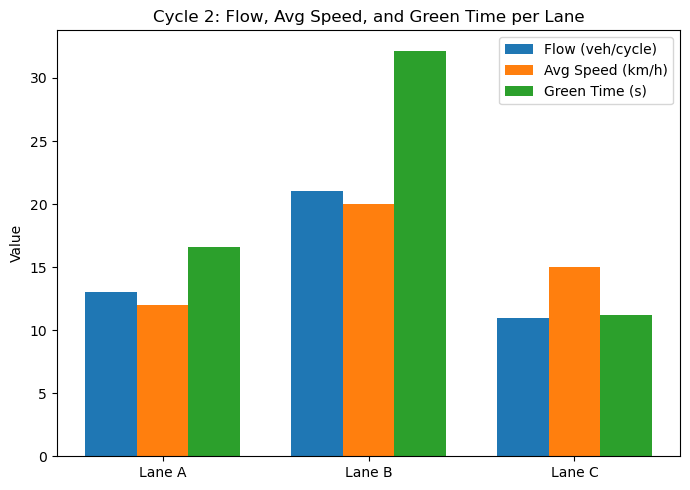

In [26]:

# --- Plot 1: Bar chart (last cycle flow vs. green time) ---
# --- Plot 1: Bar chart (Flow | Avg Speed | Green Time for selected cycle) ---

cycle = 2  # choose cycle index (-1 = last cycle, or e.g. 4 for 5th cycle)

fig1, ax1 = plt.subplots(figsize=(7,5))
x = np.arange(n_lanes)
width = 0.25

ax1.bar(x - width, [flow[lane][cycle] for lane in lanes], width, label="Flow (veh/cycle)")
ax1.bar(x, [avg_speed[lane][cycle] for lane in lanes], width, label="Avg Speed (km/h)")
ax1.bar(x + width, raw_green[cycle, :], width, label="Green Time (s)")

ax1.set_ylabel("Value")
ax1.set_title(f"Cycle {cycle if cycle != -1 else n_cycles}: Flow, Avg Speed, and Green Time per Lane")
ax1.set_xticks(x)
ax1.set_xticklabels(lanes)
ax1.legend()

plt.tight_layout()


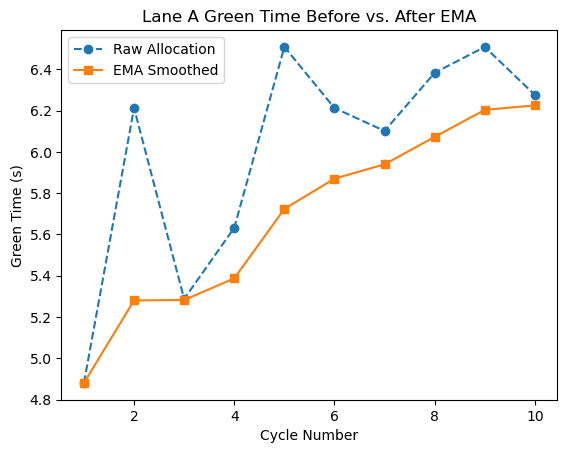

In [24]:

# --- Plot 2: Green Time Before vs After EMA (Lane A) ---
fig2, ax2 = plt.subplots()
ax2.plot(cycles, green_time["Lane A"], marker="o", linestyle="--", label="Raw Allocation")
ax2.plot(cycles, green_time_ema["Lane A"], marker="s", label="EMA Smoothed")

ax2.set_title("Lane A Green Time Before vs. After EMA")
ax2.set_xlabel("Cycle Number")
ax2.set_ylabel("Green Time (s)")
ax2.legend()


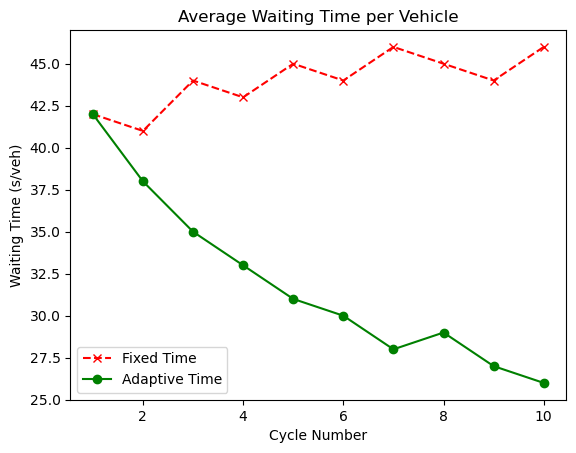

In [25]:

# --- Plot 3: Waiting time comparison ---
fig3, ax3 = plt.subplots()
ax3.plot(cycles, waiting_fixed, marker="x", color="red", linestyle="--", label="Fixed Time")
ax3.plot(cycles, waiting_adapt, marker="o", color="green", label="Adaptive Time")

ax3.set_title("Average Waiting Time per Vehicle")
ax3.set_xlabel("Cycle Number")
ax3.set_ylabel("Waiting Time (s/veh)")
ax3.legend()

plt.show()
